# Large DRO

---

### General Setup
This section imports essential libraries for optimization, plotting, and time-tracking, which will be used throughout the experiment.

In [1]:
import pygmo as pg
import matplotlib.pyplot as plt
import time # for time.time()
from datetime import datetime
from scipy.stats import ks_2samp, ttest_ind, levene


---

### UDP and Problem
Here, we load the User Defined Problem (UDP) and initialize the problem for optimization. For this experiment, we're using the "large-dro" problem, a more complex optimization challenge.

In [2]:
from problems.golomb_medium import udp
problem = pg.problem(udp)
from problems.golomb_medium import udp as tight_udp
tight_problem = pg.problem(tight_udp)


---

### Locally Defined Imports
We import custom modules that handle specific tasks like chromosome manipulation, file handling, generating results, and population operations. These modules contain the core logic of our experiment.

In [3]:
from chromosome_operations import *
from file_handling import *
from output_helpers import *
from population_operations import *
from results_generators import *


---

### Reloading Libraries (for Notebook Use)
To avoid restarting the Jupyter kernel after updating custom libraries, this block reloads the modules. This allows you to apply changes to these libraries on the fly during experimentation.

In [10]:
"""
RELOAD Libraries - Instead of restarting the kernel
Allows reloading of custom libraries after changes, without needing to restart the Jupyter kernel.
"""

import importlib

import problems.golomb_medium
importlib.reload(problems.golomb_medium)
from problems.golomb_medium import udp
from problems.golomb_medium import udp as tight_udp

import chromosome_operations
importlib.reload(chromosome_operations)
from chromosome_operations import *

import file_handling
importlib.reload(file_handling)
from file_handling import *

import output_helpers
importlib.reload(output_helpers)
from output_helpers import *

import population_operations
importlib.reload(population_operations)
from population_operations import *

import results_generators
importlib.reload(results_generators)
from results_generators import *

import experiments
importlib.reload(experiments)
from experiments import *


---

### Orbit Name Initialization
This block sets the orbit name for tracking and organizing population configurations specific to the problem being solved. In this case, we are working with the "large-dro" orbit.

In [17]:
ORBIT_NAME = "large-dro"
THEORETICAL_MAX = -2.7858
ACHIEVED_MAX = -1.923

---

## ***Experiment : Pool Refinement Comparison***

### Purpose
This experiment compares various satellite pool refinement methods (basic, fitness-based, and fill-factor-based) to assess their effectiveness in generating high-fitness initial satellite constellations. The goal is to determine whether refined pools lead to better performance and inform future optimization efforts.

---

### Generating results
We evaluate three different satellite pools and two chromosome generation methods for each pool:
* Satellite Pools:
   1. `unrefined`: Randomly generated satellites within bounds, only retaining alive ones.
   2. `refined`: The `unrefined` pool, with mutations applied and fitness used to select better satellites.
   3. `refined-fill-factor`: Similar to `refined`, but the selection is based on minimizing fill factor instead of fitness.
* Chromosome Generation Methods:
   1. `from-pool`: Generates chromosomes from the pool without any additional filtering.
   2. `from-pool-differentiated`: A refined method that ensures diversity by selecting distant satellites within the pool.

Additionally, we compare both methods against the `from-bounds` strategy, which generates chromosomes randomly within the UDP bounds without relying on a pre-generated pool.

The objective is to determine whether pool refinement improves the initial configurations or if the unrefined pool performs just as well.

In [10]:
"""
Pool Manager Initialization
Initialize the SatellitePoolManager and ensure the necessary pools are generated. 
If pools already exist, skip the generation step.
"""
pool_manager = SatellitePoolManager(udp, ORBIT_NAME, quiet=False)
pool_manager.ensure_all()

Refined fill factor pool 'large-dro-refined-fill-factor-500' already generated.
All necessary satellite pools are ensured for large-dro.


In [11]:
directory = f"results/{ORBIT_NAME}"
filename = "refined_pool_comparison"
json_manager = JSON_Manager(directory=directory)

# Constants
NUMBER_OF_CHROMOSOMES = 1000

# Step 1: Check if the results file already exists
if json_manager.file_exists(filename):
    print(f"Comparison already computed. Loading results from {directory}/{filename}.json.")
    pool_results, metadata = json_manager.load_with_metadata(filename, quiet=True)
else:
    """
    Loading satellite pools and evaluating fitness.
    """
    start_time = time.time()
    seed = f"refined_pool_comparison_{ORBIT_NAME}"
    random.seed(seed)

    # Step 2: Load satellite pools from files
    pool_files = pool_manager.get_filenames()
    satellite_pools = {
        pool_file: pool_manager.satellite_file_manager.load_satellites(pool_file, quiet=True)[0]
        for pool_file in pool_files
    }

    pool_results = []

    # Step 3: Iterate over pools and evaluate "from-pool" and "from-pool-differentiated"
    for pool_name, satellite_pool in satellite_pools.items():
        print(f"Evaluating pool: from-pool - {pool_name}")

        # Generate chromosomes using the "from-pool" method and evaluate fitness
        pool_results.append({
            "pool_name": f"from-{pool_name}",
            "avg_fitness": generate_chromosomes_and_evaluate_fitness(
                ChromosomeFactory(
                    udp=udp,
                    satellite_pool=satellite_pool,
                    pool_name=pool_name,
                    generation_method="from-pool"
                ),
                num_chromosomes=NUMBER_OF_CHROMOSOMES
            )
        })

        print(f"Evaluating pool: from-pool-differentiated - {pool_name}")

        # Generate chromosomes using the "from-pool-differentiated" method and evaluate fitness
        pool_results.append({
            "pool_name": f"from-{pool_name}-differentiated",
            "avg_fitness": generate_chromosomes_and_evaluate_fitness(
                ChromosomeFactory(
                    udp=udp,
                    satellite_pool=satellite_pool,
                    pool_name=pool_name,
                    generation_method="from-pool-differentiated"
                ),
                num_chromosomes=NUMBER_OF_CHROMOSOMES
            )
        })

    # Step 4: Generate and evaluate "from-bounds" chromosomes
    print(f"Evaluating method: from-bounds")
    pool_results.append({
        "pool_name": "from-bounds",
        "avg_fitness": generate_chromosomes_and_evaluate_fitness(
            ChromosomeFactory(
                udp=udp,
                satellite_pool=[],
                pool_name="from-bounds",
                generation_method="from-bounds"
            ),
            num_chromosomes=NUMBER_OF_CHROMOSOMES
        )
    })

    # Step 5: Save results with metadata
    metadata = {
        "orbit": ORBIT_NAME,
        "description": "Comparison of fitness results between different satellite pool generation methods.",
        "num_chromosomes": NUMBER_OF_CHROMOSOMES,
        "satellite_pool_files": pool_files,
        "methods": ["from-pool", "from-pool-differentiated", "from-bounds"],
        "elapsed_time_sec": time.time() - start_time,
        "seed": seed,
        "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    json_manager.save_with_metadata(filename, metadata, pool_results)
    print(f"Results saved to {directory}/{filename}.json.")

Refined fill factor pool 'large-dro-refined-fill-factor-500' already generated.
Loaded data from satellites/large-dro-alive-pool-500.json
Loaded data from satellites/large-dro-refined-500.json
Loaded data from satellites/large-dro-refined-fill-factor-500.json
Evaluating pool: from-pool - large-dro-alive-pool-500
Evaluating pool: from-pool-differentiated - large-dro-alive-pool-500
Evaluating pool: from-pool - large-dro-refined-500
Evaluating pool: from-pool-differentiated - large-dro-refined-500
Evaluating pool: from-pool - large-dro-refined-fill-factor-500
Evaluating pool: from-pool-differentiated - large-dro-refined-fill-factor-500
Evaluating method: from-bounds
Saved data to results/large-dro/refined_pool_comparison.json
Results saved to results/large-dro/refined_pool_comparison.json.



---

### Plotting
We plot the fitness distributions for each pool and method using histograms and box plots. This provides a visual comparison of how well each method performed in terms of generating high-fitness constellations.

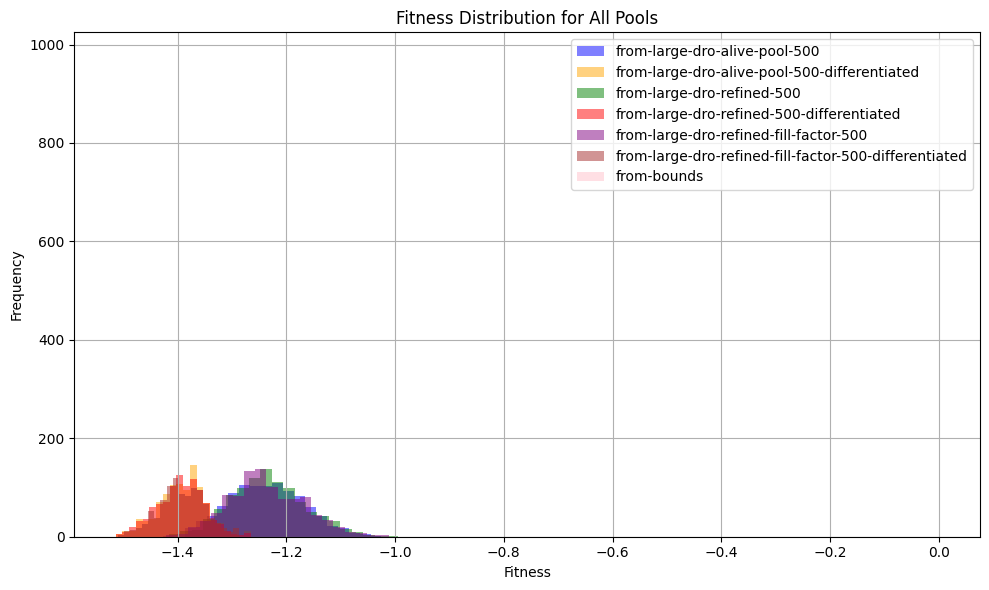

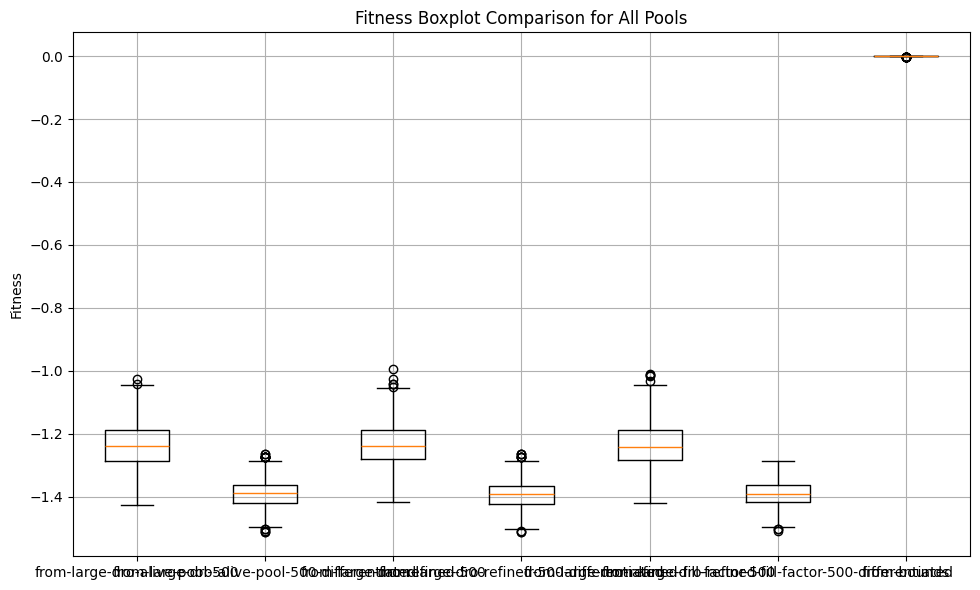

In [12]:
plot_fitness_histograms_and_box_plots(pool_results)

---

### Results

We calculate and display statistical summaries for each pool and method, including mean, median, quartiles, and standard deviation. These statistics will help quantify how much pool refinement impacts the initial fitness of constellations.

In [13]:
for result in pool_results:
    print_fitness_stats(result["avg_fitness"], result["pool_name"])


--- Statistics for fitness from : from-large-dro-alive-pool-500 ---
Min: -1.42713
Q1 (25th percentile): -1.28554
Median (Q2): -1.23795
Q3 (75th percentile): -1.18917
Max: -1.02499
Mean: -1.23576
Standard Deviation: 0.06841

--- Statistics for fitness from : from-large-dro-alive-pool-500-differentiated ---
Min: -1.51398
Q1 (25th percentile): -1.41880
Median (Q2): -1.38905
Q3 (75th percentile): -1.36288
Max: -1.26532
Mean: -1.39189
Standard Deviation: 0.04277

--- Statistics for fitness from : from-large-dro-refined-500 ---
Min: -1.41642
Q1 (25th percentile): -1.28079
Median (Q2): -1.23795
Q3 (75th percentile): -1.18917
Max: -0.99524
Mean: -1.23393
Standard Deviation: 0.06824

--- Statistics for fitness from : from-large-dro-refined-500-differentiated ---
Min: -1.51398
Q1 (25th percentile): -1.42237
Median (Q2): -1.39262
Q3 (75th percentile): -1.36496
Max: -1.26532
Mean: -1.39435
Standard Deviation: 0.04333

--- Statistics for fitness from : from-large-dro-refined-fill-factor-500 ---
Mi


---

### Observations
* The different pool refinement strategies (both fitness-based and fill-factor-based) did not lead to significant improvements in the initial population fitness when compared to the unrefined pool.
* In some cases, the from-pool-differentiated method using the unrefined pool actually outperformed the refined pools.
* Refinement methods seem to add computational overhead without yielding clear fitness benefits, suggesting that the added complexity may not be justified for this problem.

<br>

---

### Conclusion
Given these findings, we will pivot away from refining the satellite pool prior to initialization. Instead, the focus will shift toward optimizing how the unrefined pool is used to generate stronger initial populations. Specifically:

* We will experiment with advanced chromosome generation techniques that leverage the unrefined pool to maximize diversity and fitness.
* The goal moving forward will be to generate stronger initial populations and then evolve these populations to achieve higher fitness scores in less time.
* Refining the population post-initialization will be explored further, building on the best configurations obtained from the unrefined pool.

<br>

---

## ***Experiment : Distance Metric Comparison***
### Purpose
This experiment aims to compare various distance metrics (e.g., Manhattan, Euclidean) for generating chromosomes from a satellite pool using the `from-pool-differentiated` method. The goal is to determine which distance metric yields the most optimized initial chromosome configurations. The results will guide us in selecting the best metric for future experiments.

---

### Generating Results
We will use the available distance metrics from the DistanceMetric class to generate 1000 chromosomes for each metric. These chromosomes will be generated using the from-pool-differentiated method and the alive satellite pool. We will evaluate their fitness and save the results for comparison.

This first block will print out the different metrics will will be comparing

In [14]:
for metric_name in DistanceMetric.get_metrics():
    print(metric_name)

manhattan
geometric
velocity
position
orbital


---

In [15]:
directory = f"results/{ORBIT_NAME}"
filename = "distance_metric_comparison"
json_manager = JSON_Manager(directory=directory)

# Constants
NUMBER_OF_CHROMOSOMES = 1000

# Step 1: Check if the results file already exists
if json_manager.file_exists(filename):
    print(f"Comparison already computed. Loading results from {directory}/{filename}.json.")
    distance_metric_results, metadata = json_manager.load_with_metadata(filename, quiet=True)
else:
    start_time = time.time()
    seed = f"distance_metric_comparison_{ORBIT_NAME}"
    random.seed(seed)

    # Step 2: Load satellite pools from files
    pool_filename = pool_manager.get_filenames()[0]
    satellite_pool = pool_manager.satellite_file_manager.load_satellites(pool_filename, quiet=True)[0]

    distance_metric_results = []

    for metric_name in DistanceMetric.get_metrics():
        print(f"Evaluating for distance metric: {metric_name}")


        # Generate chromosomes using the "from-pool" method and evaluate fitness
        distance_metric_results.append({
            "metric_name": f"differentiated-{metric_name}",
            "avg_fitness": generate_chromosomes_and_evaluate_fitness(
                ChromosomeFactory(
                    udp=udp,
                    satellite_pool=satellite_pool,
                    pool_name=pool_filename,
                    metric_name=metric_name,
                    generation_method="from-pool-differentiated"
                ),
                num_chromosomes=NUMBER_OF_CHROMOSOMES
            )
        })

    # Step 4: Generate and evaluate "from-bounds" chromosomes
    print(f"Evaluating method: from-pool")
    distance_metric_results.append({
        "metric_name": "from-pool",
        "avg_fitness": generate_chromosomes_and_evaluate_fitness(
            ChromosomeFactory(
                udp=udp,
                satellite_pool=satellite_pool,
                pool_name=pool_filename,
                metric_name="none",  # No metric for basic from-pool method
                generation_method="from-pool"
            ),
            num_chromosomes=NUMBER_OF_CHROMOSOMES
        )
    })

    # Step 5: Save results with metadata
    metadata = {
        "orbit": ORBIT_NAME,
        "description": "Comparison of fitness results between distance metrics use in from-pool-differentiated.",
        "num_chromosomes": NUMBER_OF_CHROMOSOMES,
        "satellite_pool_files": pool_filename,
        "metrics": [f"from-pool-differentiated-{metric_name}" for metric_name in DistanceMetric.get_metrics()] + ["from-pool"],
        "elapsed_time_sec": time.time() - start_time,
        "seed": seed,
        "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    json_manager.save_with_metadata(filename, metadata, distance_metric_results)
    print(f"Results saved to {directory}/{filename}.json.")

Refined fill factor pool 'large-dro-refined-fill-factor-500' already generated.
Loaded data from satellites/large-dro-alive-pool-500.json
Evaluating for distance metric: manhattan
Evaluating for distance metric: geometric
Evaluating for distance metric: velocity
Evaluating for distance metric: position
Evaluating for distance metric: orbital
Evaluating method: from-pool
Saved data to results/large-dro/distance_metric_comparison.json
Results saved to results/large-dro/distance_metric_comparison.json.


---

### Plotting
We will plot histograms and box plots to compare the fitness distributions across the different distance metrics. This visualization will help us identify the distance metric that consistently produces higher fitness values.

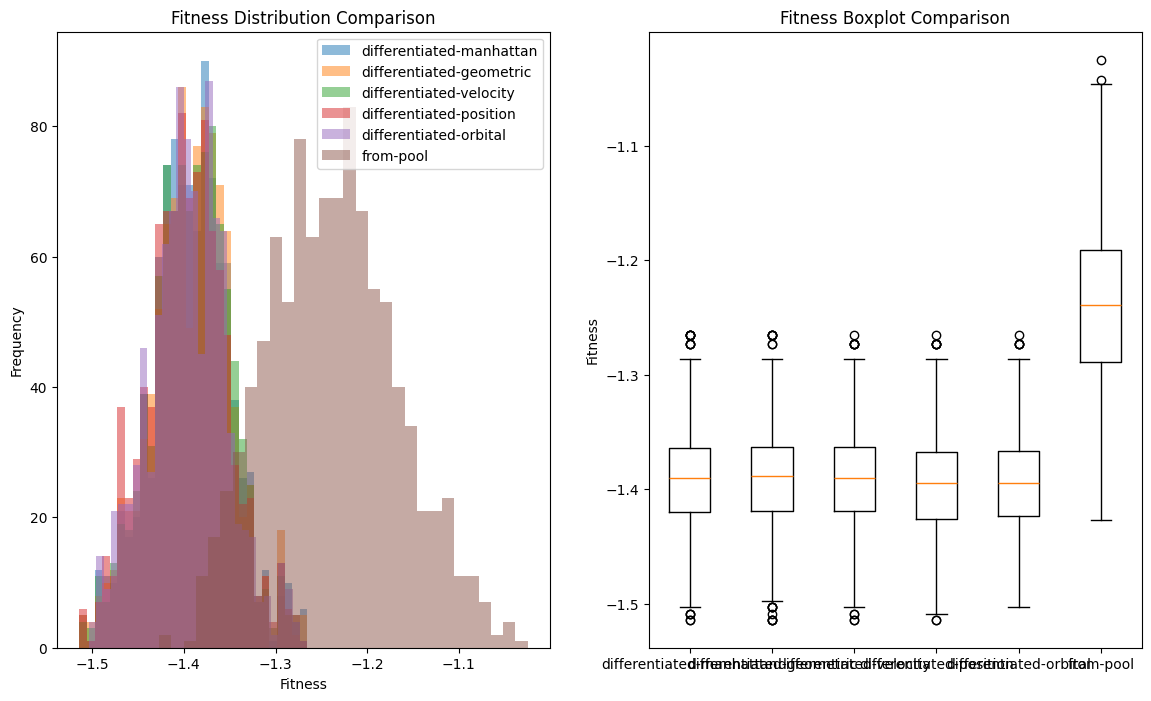

In [16]:
plot_distance_metric_comparison(distance_metric_results)

---

### Results
We will print detailed statistical results for each metric, including mean, standard deviation, min, max, and quartiles.

In [17]:
for result in distance_metric_results:
    print_fitness_stats(result["avg_fitness"], result["metric_name"])


--- Statistics for fitness from : differentiated-manhattan ---
Min: -1.51398
Q1 (25th percentile): -1.41999
Median (Q2): -1.39024
Q3 (75th percentile): -1.36407
Max: -1.26532
Mean: -1.39173
Standard Deviation: 0.04402

--- Statistics for fitness from : differentiated-geometric ---
Min: -1.51398
Q1 (25th percentile): -1.41880
Median (Q2): -1.38846
Q3 (75th percentile): -1.36288
Max: -1.26532
Mean: -1.39192
Standard Deviation: 0.04397

--- Statistics for fitness from : differentiated-velocity ---
Min: -1.51398
Q1 (25th percentile): -1.41910
Median (Q2): -1.39024
Q3 (75th percentile): -1.36288
Max: -1.26532
Mean: -1.39205
Standard Deviation: 0.04300

--- Statistics for fitness from : differentiated-position ---
Min: -1.51398
Q1 (25th percentile): -1.42594
Median (Q2): -1.39500
Q3 (75th percentile): -1.36764
Max: -1.26532
Mean: -1.39634
Standard Deviation: 0.04429

--- Statistics for fitness from : differentiated-orbital ---
Min: -1.50327
Q1 (25th percentile): -1.42356
Median (Q2): -1.395

---

### Observations:
* Across all distance metrics used in the "differentiated" method, the results show extremely similar fitness statistics.
* The minimum fitness values for all differentiated methods are identical at -1.17965, with slight variations in the first quartile (Q1), median, and third quartile (Q3) values.
* The differences between the mean fitness values for the different metrics are negligible, all hovering around -1.071 to -1.074. The standard deviations across the different metrics also show little variance, indicating consistent performance across different distance metrics.
* In contrast, the "from-pool" method (without differentiation) performed worse overall, with a significantly higher mean (-0.95542) and greater variation in fitness values, as seen from a larger standard deviation (0.05799).
* The boxplots for the differentiated methods overlap heavily, reflecting the near-identical performance.

<br>

---

### Conclusion:
Given the near-identical performance of the various distance metrics, we can conclude that the choice of distance metric does not significantly impact the results when using the "from-pool-differentiated" method for this problem. Therefore, we can move forward using the `manhattan` metric as a default for future experiments, simplifying the pipeline without sacrificing performance. This will allow us to focus on other aspects of optimization rather than fine-tuning distance metrics. The `from-pool` method, while significantly faster, continues to underperform compared to all differentiated methods, and thus we will deprioritize its use for future configurations.

<br>

---

## ***Experiment: Satellite Component Distribution vs Fitness***

### Purpose
This experiment aims to investigate the relationship between the individual components of satellite configurations (x, y, z, xv, yv, zv) and their corresponding fitness. By plotting each of these satellite components against fitness, we aim to identify any patterns or trends that might inform a more effective way of generating initial satellite configurations for optimization.

---

### Generating Results
We will:
1. Generate a large number of satellite configurations using the `from-pool` method.
2. Decompose each configuration into individual satellites and extract their components (`x, y, z, xv, yv, zv`).
3. Calculate the fitness of each configuration.
4. Collect the values for each component along with the corresponding fitness.

In [18]:
# Constants
NUMBER_OF_CHROMOSOMES = 1000

pool_filename = pool_manager.get_filenames()[0]
satellite_pool = pool_manager.satellite_file_manager.load_satellites(pool_filename, quiet=True)[0]
chromosome_controller = ChromosomeController(udp)


# Initialize ChromosomeFactory using the "from-pool" method
chromosome_factory = ChromosomeFactory(
    udp=udp,
    satellite_pool=satellite_pool,
    pool_name=pool_filename,
    generation_method="from-pool"
)

# Step 1: Generate chromosomes and decompose into satellite components
satellite_components = []  # To store the decomposed satellite components
fitness_values = []  # To store corresponding fitness values




for _ in range(NUMBER_OF_CHROMOSOMES):
    chromosome = chromosome_factory()

    # Decompose the chromosome into individual satellites
    decomposed_satellites = chromosome_controller.decompose(chromosome)
    
    # Calculate the fitness for this chromosome
    fitness = udp.fitness(chromosome)[0]  # Get the fitness as a single float
    
    # Store the satellite components and fitness
    for satellite in decomposed_satellites:
        satellite_components.append(satellite)  # Each satellite is [x, y, z, xv, yv, zv]
        fitness_values.append(fitness)





Refined fill factor pool 'large-dro-refined-fill-factor-500' already generated.
Loaded data from satellites/large-dro-alive-pool-500.json


---

### Plotting
We will plot each satellite component (`x, y, z, xv, yv, zv`) against their corresponding fitness values to check for any patterns or correlations.

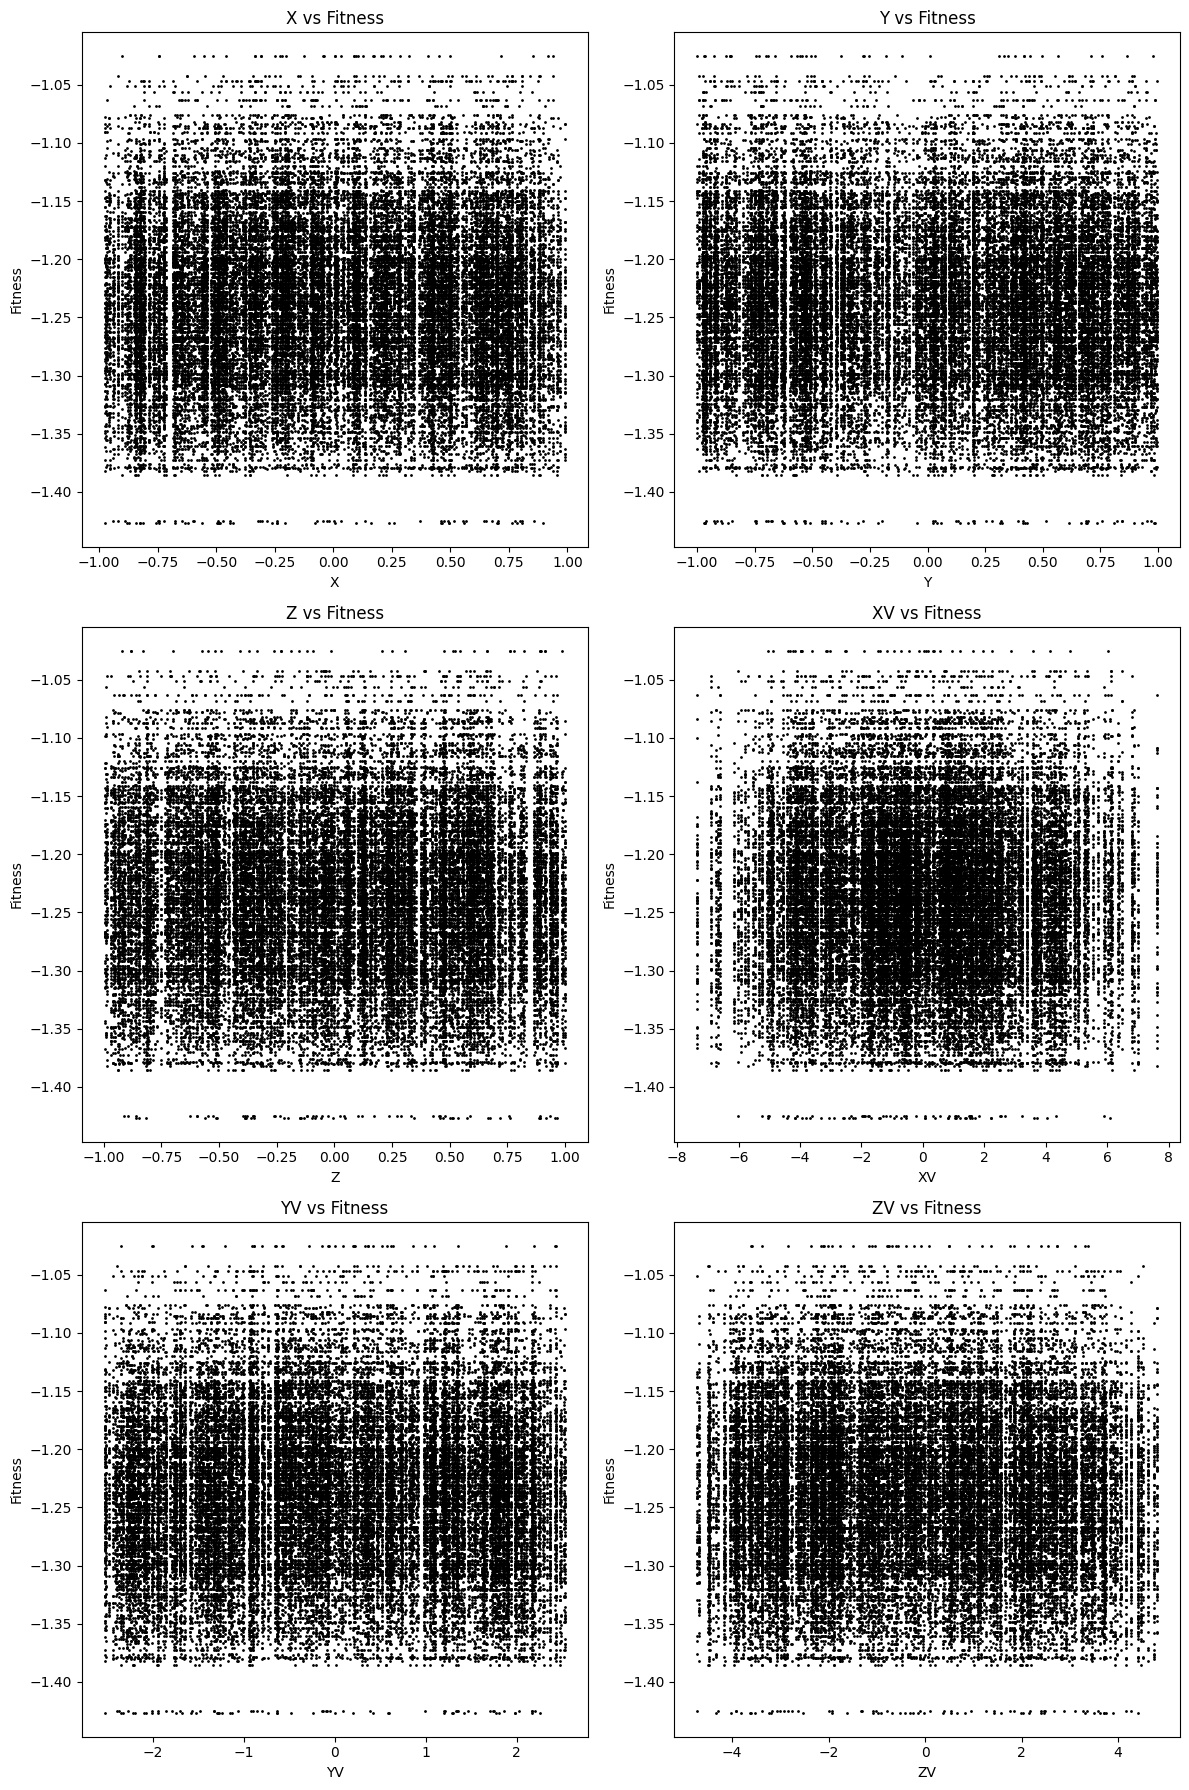

In [19]:
# Step 2: Plot satellite components vs fitness
components = ['x', 'y', 'z', 'xv', 'yv', 'zv']

# Decompose satellite components into separate lists
x_vals, y_vals, z_vals, xv_vals, yv_vals, zv_vals = zip(*satellite_components)

# Step 3: Create scatter plots for each component vs fitness
plt.figure(figsize=(12, 18))

for i, (component_vals, component_name) in enumerate(zip([x_vals, y_vals, z_vals, xv_vals, yv_vals, zv_vals], components), start=1):
    plt.subplot(3, 2, i)
    plt.scatter(component_vals, fitness_values, s=1, color="black")
    plt.title(f'{component_name.upper()} vs Fitness')
    plt.xlabel(f'{component_name.upper()}')
    plt.ylabel('Fitness')
    plt.grid(False)

plt.tight_layout()
plt.show()

---

### Results
We will show the min, max, mean, and standard deviation for each satellite component to explore their ranges and potential correlation with fitness.

In [20]:
# Step 4: Calculate statistics for each component
for component_vals, component_name in zip([x_vals, y_vals, z_vals, xv_vals, yv_vals, zv_vals], components):
    print(f"--- Statistics for {component_name.upper()} ---")
    print(f"Min: {np.min(component_vals):.5f}")
    print(f"Max: {np.max(component_vals):.5f}")
    print(f"Mean: {np.mean(component_vals):.5f}")
    print(f"Standard Deviation: {np.std(component_vals):.5f}")
    print()

--- Statistics for X ---
Min: -0.97578
Max: 0.98787
Mean: 0.00970
Standard Deviation: 0.53167

--- Statistics for Y ---
Min: -0.99953
Max: 0.99534
Mean: 0.00543
Standard Deviation: 0.58430

--- Statistics for Z ---
Min: -0.99575
Max: 0.99732
Mean: 0.01502
Standard Deviation: 0.53440

--- Statistics for XV ---
Min: -7.34751
Max: 7.62224
Mean: 0.02931
Standard Deviation: 3.02549

--- Statistics for YV ---
Min: -2.52694
Max: 2.52435
Mean: 0.02435
Standard Deviation: 1.39508

--- Statistics for ZV ---
Min: -4.72431
Max: 4.80694
Mean: -0.21460
Standard Deviation: 2.41803



---

### Observations
Based on the statistics generated for the individual satellite parameters (X, Y, Z, XV, YV, ZV) and their respective fitness values, we observed the following:


<br>

---

### Conclusion
Based on the results, shrinking the bounds for satellite generation could lead to a significant increase in speed and more efficient initialization of the satellite pool, especially for parameters like Z, XV, YV, and ZV, where most of the useful (alive) satellites are concentrated near the center of the range.
By reducing the search space in the UDP’s bounds:
* Speed Improvement: While not formally tested yet, the reduced bounds could speedup generating alive satellites when tighter bounds were used.
* Convergence Speed: While not formally tested yet, the reduced bounds could also improve convergence speed by focusing the search on regions where satellites are more likely to survive.

Next steps will involve testing the effects of these tighter bounds during evolution and further evaluating their impact on overall solution quality and convergence speed. If successful, this approach could be a key factor in speeding up the optimization process without sacrificing result quality.

<br>

---

---

## ***Experiment: Testing Speed and Effectiveness of Tight vs. Full Bounds***

### Purpose
This experiment compares the speed and effectiveness of satellite generation using dynamically calculated tight bounds versus the full default bounds. The goal is to reduce the time needed to generate alive satellites without compromising their fitness.

---

### Generating Results: Alive Satellite Generation Speed Test
We will measure the time taken to generate 500 alive satellites using both default full bounds and tighter custom bounds based on satellite component statistics.

In [27]:
def set_expansion_bounds(udp, x_vals, y_vals, z_vals, xv_vals, yv_vals, zv_vals, expansion_factor=0.5):
    lower_bounds = []
    upper_bounds = []
    for vals in (x_vals, y_vals, z_vals, xv_vals, yv_vals, zv_vals):
        lower_bounds.append(min(vals) - expansion_factor)
        upper_bounds.append(max(vals) + expansion_factor)

    actual_bounds = [1,1,1,10, 10,10]
    for i in range(6):
        if lower_bounds[i] < -actual_bounds[i]:
            lower_bounds[i] = -actual_bounds[i]
        if lower_bounds[i] > actual_bounds[i]:
            lower_bounds[i] = actual_bounds[i]

    udp.set_custom_bounds(lower_bounds, upper_bounds)
    udp.set_custom_bounds_switch(True)

expansion_factor = 0.1  # Change this to test different factors
set_expansion_bounds(tight_udp, x_vals, y_vals, z_vals, xv_vals, yv_vals, zv_vals, expansion_factor)

In [28]:
random.seed("Default bounds")

# Default bounds (run if not already defined)
if 'default_time' not in globals() or 'default_pool' not in globals():
    default_time, default_pool = time_alive_generation(udp, target=500, use_tight_bounds=False)
    print(f"Time with default bounds: {default_time:.2f} seconds for {len(default_pool)} satellites")
else:
    print("Default bounds generation already done. Skipping...")

# Tight bounds
random.seed("Tight bounds")
tight_time, tight_pool = time_alive_generation(tight_udp, target=500, use_tight_bounds=True)
print(f"Time with tight bounds: {tight_time:.2f} seconds for {len(tight_pool)} satellites")

Progress: |██████████████████████████████████████████████████| 100.0% complete | Elapsed: 00:00:15 | Remaining: 00:00:00 |  Finish: 11:55 | 0.032%    
Time with default bounds: 15.62 seconds for 500 satellites
Progress: |██████████████████████████████████████████████████| 100.0% complete | Elapsed: 00:00:01 | Remaining: 00:00:00 |  Finish: 11:55 | 0.31%    
Time with tight bounds: 1.59 seconds for 500 satellites


---

### Plotting
The following plots compare the tight bounds and full bounds data for satellite components in 2D planes (`xy`, `xz`, `yz`, `xyv``,` `xzv`, `yzv`). The first set of plots shows them side by side for visual comparison, while the second set overlays them on a single graph to highlight any differences.

---

**First Plot: Side-by-Side Comparison of Tight vs. Full Bounds**

The side-by-side plots show the distribution of satellite components in each plane, separately for tight bounds (green) and full bounds (blue). This helps us visually assess whether the tighter bounds capture the same regions of the configuration space as the full bounds.

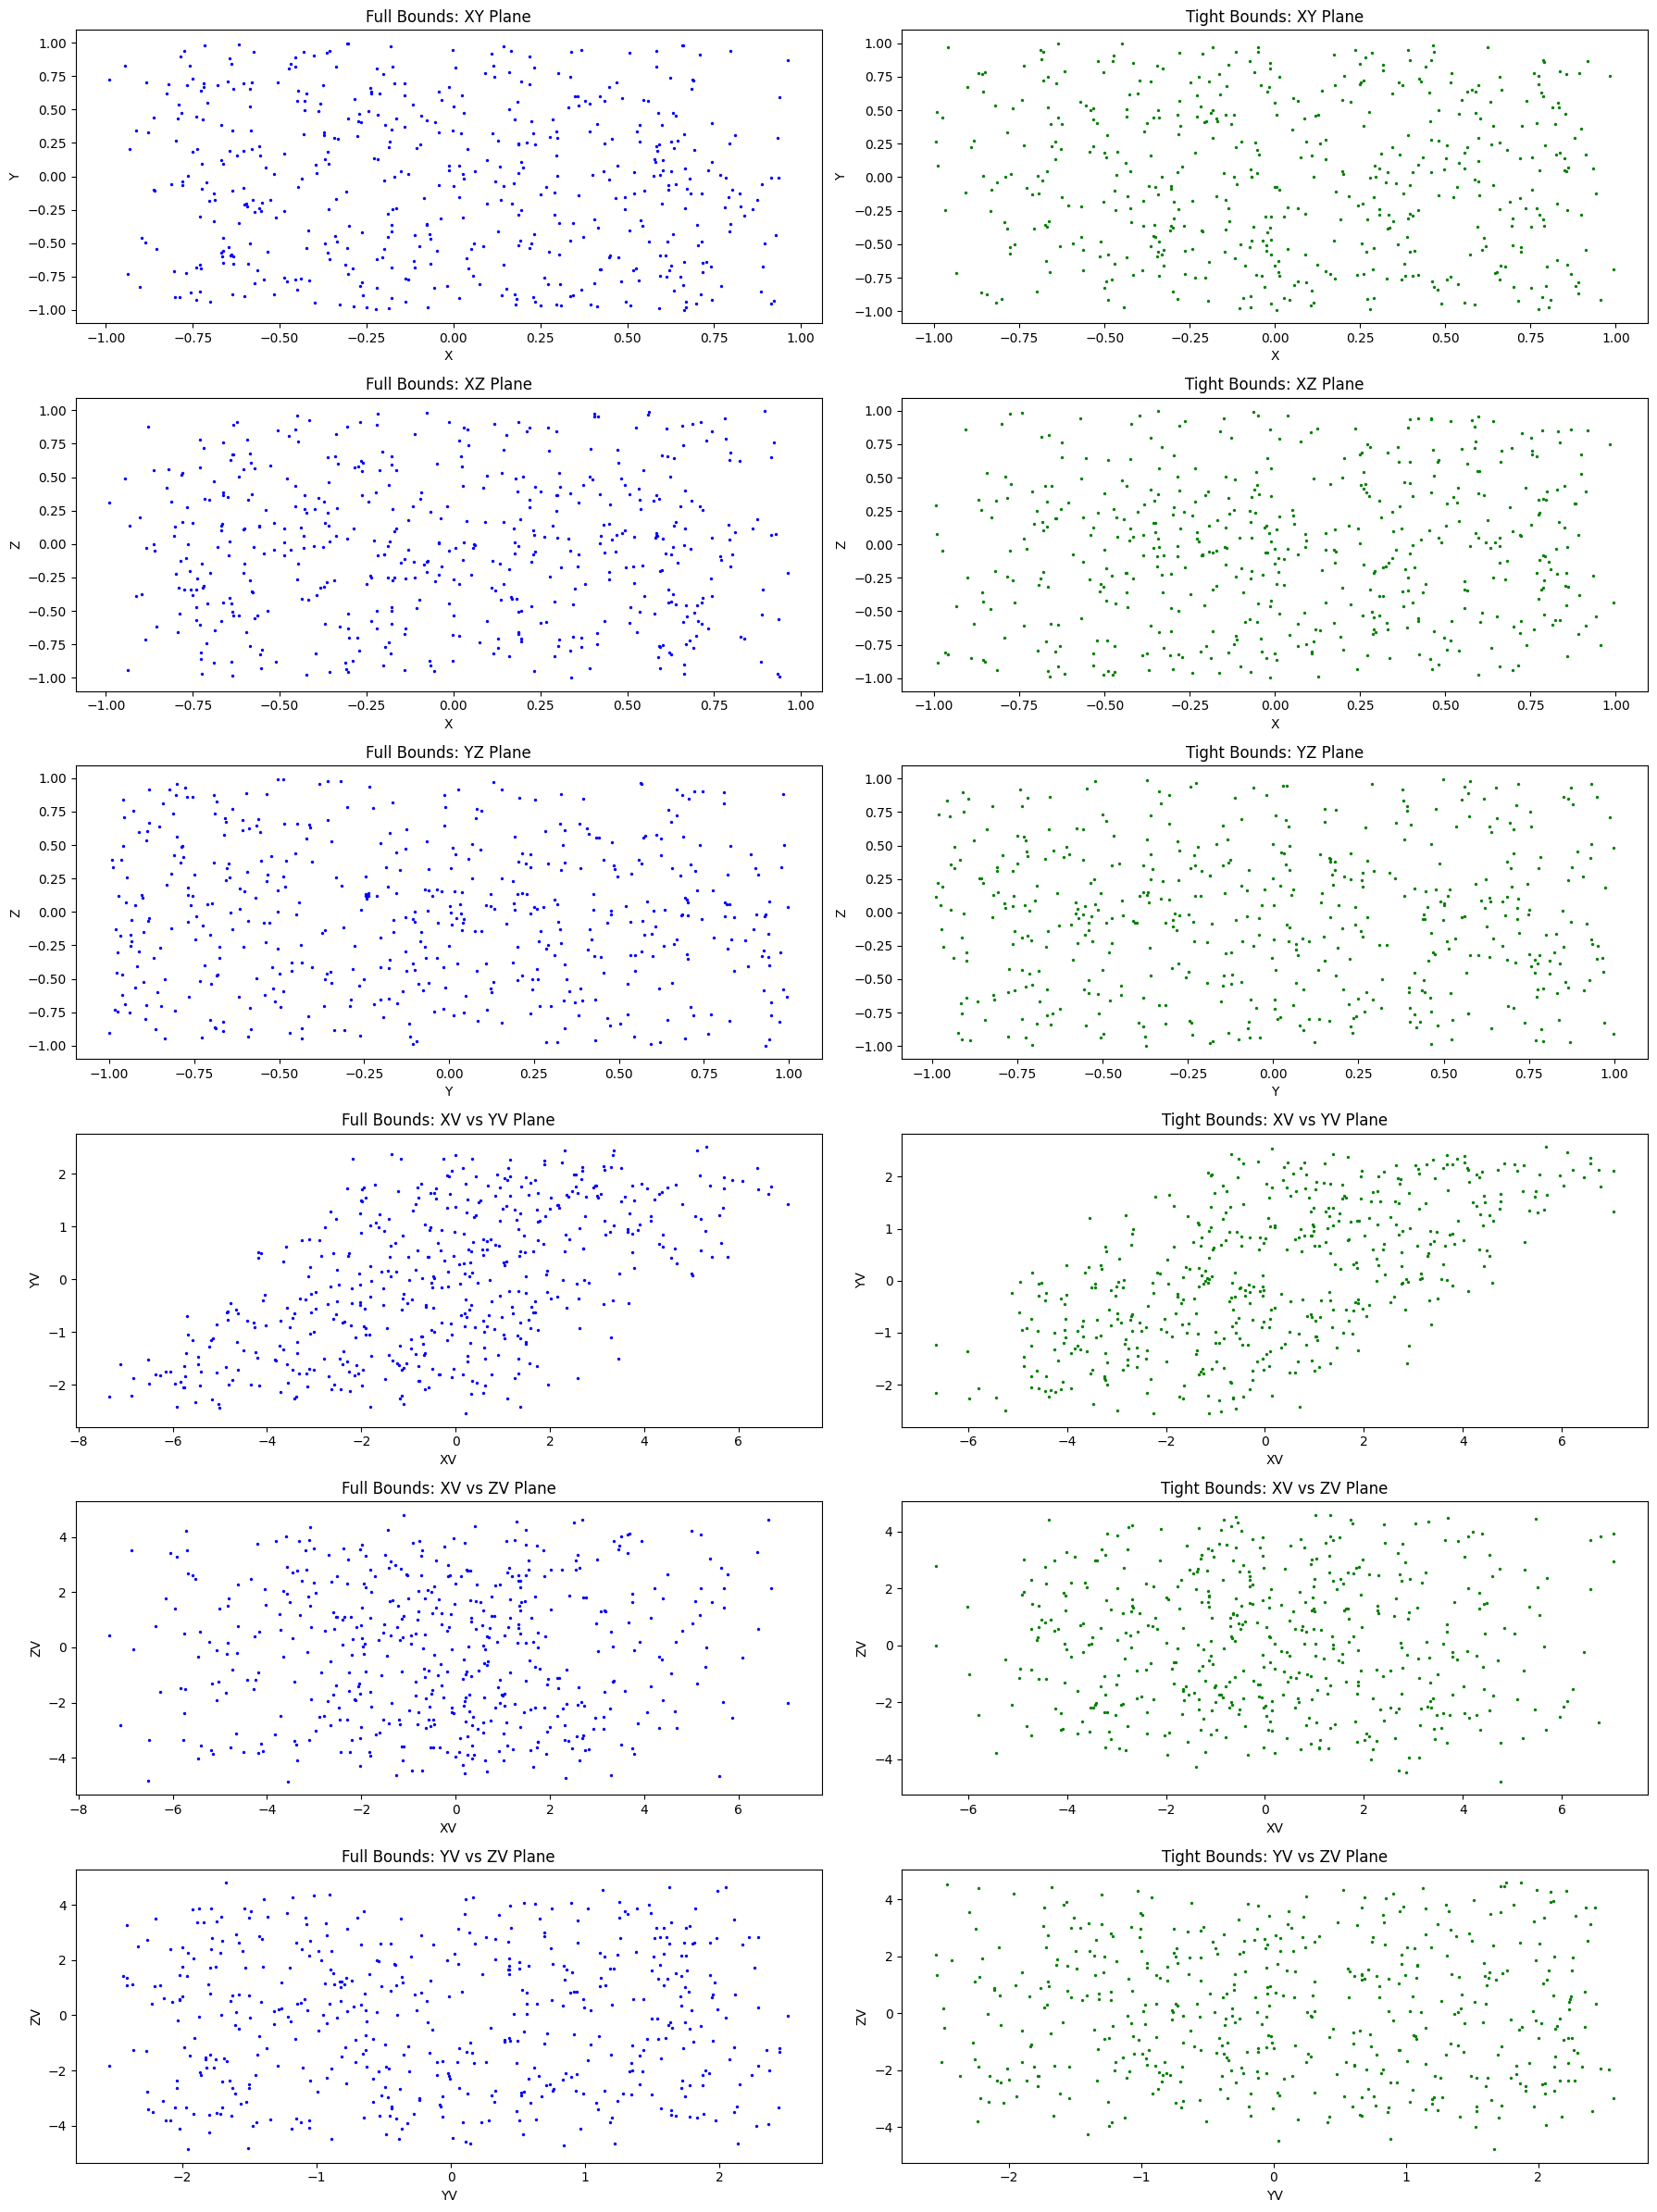

In [29]:
# Step 1: Decompose satellite components into separate lists for full and tight bounds
x_full, y_full, z_full, xv_full, yv_full, zv_full = zip(*default_pool)
x_tight, y_tight, z_tight, xv_tight, yv_tight, zv_tight = zip(*tight_pool)

# Step 2: Set up the planes to be plotted
planes = [
    ('x', 'y', x_full, y_full, x_tight, y_tight, 'XY Plane'),
    ('x', 'z', x_full, z_full, x_tight, z_tight, 'XZ Plane'),
    ('y', 'z', y_full, z_full, y_tight, z_tight, 'YZ Plane'),
    ('xv', 'yv', xv_full, yv_full, xv_tight, yv_tight, 'XV vs YV Plane'),
    ('xv', 'zv', xv_full, zv_full, xv_tight, zv_tight, 'XV vs ZV Plane'),
    ('yv', 'zv', yv_full, zv_full, yv_tight, zv_tight, 'YV vs ZV Plane')
]

# Step 3: Plot the planes for both full and tight bounds
plt.figure(figsize=(18, 24))  # Adjust the figure size as needed

for i, (comp1, comp2, full_vals1, full_vals2, tight_vals1, tight_vals2, plane_name) in enumerate(planes, start=1):
    # Full bounds plot (left)
    plt.subplot(len(planes), 2, 2*i-1)
    plt.scatter(full_vals1, full_vals2, s=2, color="blue", label="Full Bounds")
    plt.title(f'Full Bounds: {plane_name}')
    plt.xlabel(f'{comp1.upper()}')
    plt.ylabel(f'{comp2.upper()}')
    plt.grid(False)

    # Tight bounds plot (right)
    plt.subplot(len(planes), 2, 2*i)
    plt.scatter(tight_vals1, tight_vals2, s=2, color="green", label="Tight Bounds")
    plt.title(f'Tight Bounds: {plane_name}')
    plt.xlabel(f'{comp1.upper()}')
    plt.ylabel(f'{comp2.upper()}')
    plt.grid(False)

plt.tight_layout()
plt.show()

---

***Second Plot: Overlay of Tight and Full Bounds on the Same Plot***

In these plots, both tight (green) and full bounds (blue) data are plotted together on the same axes for each plane. This helps highlight areas of overlap or differences between the two datasets. By observing any areas where tight bounds fail to capture data points from the full bounds, we can assess whether the tight bounds provide adequate coverage.

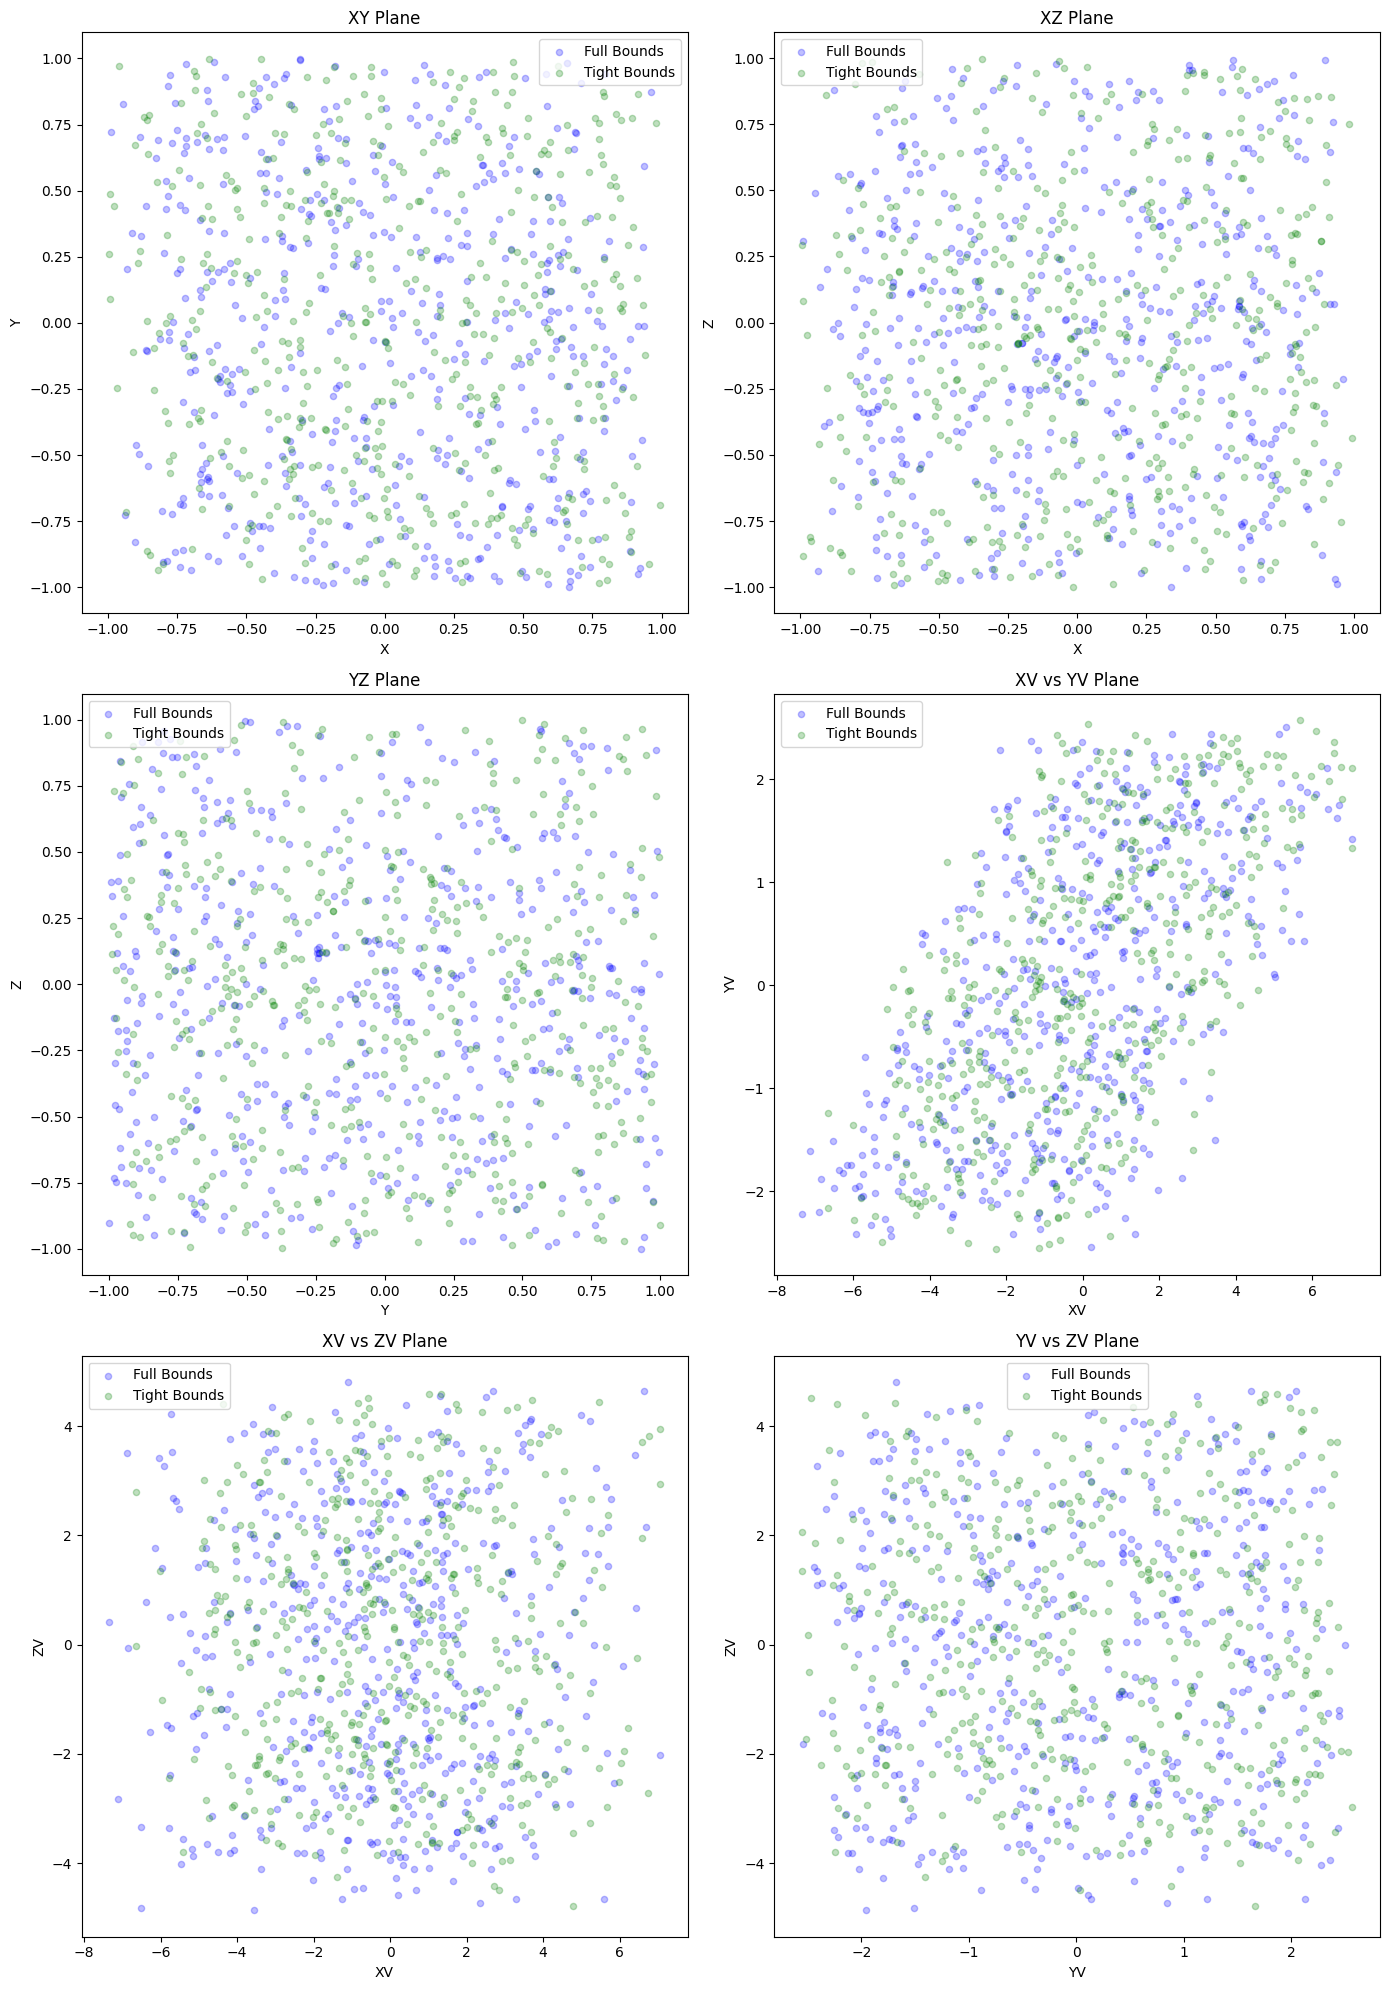

In [30]:
# Step 1: Decompose satellite components into separate lists for full and tight bounds
x_full, y_full, z_full, xv_full, yv_full, zv_full = zip(*default_pool)
x_tight, y_tight, z_tight, xv_tight, yv_tight, zv_tight = zip(*tight_pool)

# Step 2: Set up the planes to be plotted
planes = [
    ('x', 'y', x_full, y_full, x_tight, y_tight, 'XY Plane'),
    ('x', 'z', x_full, z_full, x_tight, z_tight, 'XZ Plane'),
    ('y', 'z', y_full, z_full, y_tight, z_tight, 'YZ Plane'),
    ('xv', 'yv', xv_full, yv_full, xv_tight, yv_tight, 'XV vs YV Plane'),
    ('xv', 'zv', xv_full, zv_full, xv_tight, zv_tight, 'XV vs ZV Plane'),
    ('yv', 'zv', yv_full, zv_full, yv_tight, zv_tight, 'YV vs ZV Plane')
]

# Step 3: Plot the planes with both datasets overlapping
plt.figure(figsize=(14, 20))  # Adjust the figure size as needed

for i, (comp1, comp2, full_vals1, full_vals2, tight_vals1, tight_vals2, plane_name) in enumerate(planes, start=1):
    plt.subplot(3, 2, i)
    plt.scatter(full_vals1, full_vals2, s=20, color="blue", label="Full Bounds", alpha=0.25)
    plt.scatter(tight_vals1, tight_vals2, s=20, color="green", label="Tight Bounds", alpha=0.25)
    plt.title(f'{plane_name}')
    plt.xlabel(f'{comp1.upper()}')
    plt.ylabel(f'{comp2.upper()}')
    plt.legend()
    plt.grid(False)

plt.tight_layout()
plt.show()

In [31]:
def compare_pools_statistically(pool1, pool2):
    """
    Compare two pools of satellite data statistically using multiple tests.

    Args:
        pool1: First pool of satellite data (list of lists).
        pool2: Second pool of satellite data (list of lists).
    """
    # Decompose the pools into individual components (x, y, z, xv, yv, zv)
    x1_vals, y1_vals, z1_vals, xv1_vals, yv1_vals, zv1_vals = zip(*pool1)
    x2_vals, y2_vals, z2_vals, xv2_vals, yv2_vals, zv2_vals = zip(*pool2)

    # Combine all component lists
    components = ["X", "Y", "Z", "XV", "YV", "ZV"]
    pool1_vals = [x1_vals, y1_vals, z1_vals, xv1_vals, yv1_vals, zv1_vals]
    pool2_vals = [x2_vals, y2_vals, z2_vals, xv2_vals, yv2_vals, zv2_vals]

    # Threshold for statistical significance
    alpha = 0.05

    # Store individual results
    significant_diff = []
    no_significant_diff = {comp: [] for comp in components}  # For grouping passed tests

    # Print detailed test results
    for comp_name, vals1, vals2 in zip(components, pool1_vals, pool2_vals):
        print(f"--- {comp_name.upper()} Component ---")

        # Kolmogorov-Smirnov Test
        ks_stat, ks_pvalue = ks_2samp(vals1, vals2)
        if ks_pvalue < alpha:
            significant_diff.append(f"{comp_name}\tKolmogorov-Smirnov - p-value = {ks_pvalue:.4f}")
        else:
            no_significant_diff[comp_name].append("Kolmogorov-Smirnov")
        print(f"Kolmogorov-Smirnov test: Stat={ks_stat:.4f}, p-value={ks_pvalue:.4f}")

        # T-test for Means
        t_stat, t_pvalue = ttest_ind(vals1, vals2, equal_var=False)
        if t_pvalue < alpha:
            significant_diff.append(f"{comp_name}\tT-test - p-value = {t_pvalue:.4f}")
        else:
            no_significant_diff[comp_name].append("T-test")
        print(f"T-test for means: Stat={t_stat:.4f}, p-value={t_pvalue:.4f}")

        # Levene's Test for Variance Comparison
        levene_stat, levene_pvalue = levene(vals1, vals2)
        if levene_pvalue < alpha:
            significant_diff.append(f"{comp_name}\tLevene's test - p-value = {levene_pvalue:.4f}")
        else:
            no_significant_diff[comp_name].append("Levene's test")
        print(f"Levene's test for variances: Stat={levene_stat:.4f}, p-value={levene_pvalue:.4f}")
        print()

    # Print summarized results
    print("\nSummarized Test Results:")

    # No significant difference section
    print("\nNo Significant Difference Detected:")
    for comp_name, tests in no_significant_diff.items():
        if len(tests) == 3:
            print(f"{comp_name}\tAll")
        elif tests:
            print(f"{comp_name}\t{', '.join(tests)}")

    # Significant difference section
    print("\nSignificant Difference Detected:")
    if significant_diff:
        for result in significant_diff:
            print(result)
    else:
        print("None")

compare_pools_statistically(default_pool, tight_pool)

--- X Component ---
Kolmogorov-Smirnov test: Stat=0.0640, p-value=0.2576
T-test for means: Stat=-1.5146, p-value=0.1302
Levene's test for variances: Stat=0.1499, p-value=0.6987

--- Y Component ---
Kolmogorov-Smirnov test: Stat=0.0460, p-value=0.6659
T-test for means: Stat=-1.0470, p-value=0.2953
Levene's test for variances: Stat=0.1365, p-value=0.7119

--- Z Component ---
Kolmogorov-Smirnov test: Stat=0.0300, p-value=0.9783
T-test for means: Stat=0.4256, p-value=0.6705
Levene's test for variances: Stat=0.1354, p-value=0.7130

--- XV Component ---
Kolmogorov-Smirnov test: Stat=0.0540, p-value=0.4599
T-test for means: Stat=-1.7388, p-value=0.0824
Levene's test for variances: Stat=0.0073, p-value=0.9320

--- YV Component ---
Kolmogorov-Smirnov test: Stat=0.0660, p-value=0.2263
T-test for means: Stat=-1.5690, p-value=0.1170
Levene's test for variances: Stat=0.2497, p-value=0.6174

--- ZV Component ---
Kolmogorov-Smirnov test: Stat=0.0880, p-value=0.0416
T-test for means: Stat=-1.5237, p-v

---

### Observations
* **Visual Similarity**: The graphs for both full and tight bounds appear nearly identical, indicating that the distributions of satellite components are very similar across the two datasets.
* **Statistical Tests**:
   * For most components, the Kolmogorov-Smirnov, T-test, and Levene’s test showed **no significant differences**, confirming the visual observation that the distributions are similar.
   * Only two components, X (Kolmogorov-Smirnov) and XV (Levene’s test), exhibited statistically significant differences, but the p-values were close to the significance threshold. This suggests that these differences are likely minor and may not meaningfully impact the overall optimization process.

<br>

---

### Conclusion
Although small statistical differences were detected in the **X** and **XV** components, the overall distributions of satellite configurations in both the full and tight bounds appear to be highly similar. Given the substantial speed improvement achieved by using tight bounds, these small differences are unlikely to justify reverting to full bounds.

To further validate the impact of tight bounds, we will proceed to the next experiment, where we will compare the fitness of randomly generated chromosomes using both the full and tight bounds. By analyzing the fitness performance, we can determine if the tighter bounds affect the optimization process or the quality of the generated solutions.

<br>

---

---

## ***Experiment: Fitness Comparison Between Default and Tight Bounds***

### Purpose
The goal of this experiment is to determine if the fitness results generated using **default bounds** and **tight bounds** are statistically different. We will compare the average fitness of chromosomes generated from each pool and use statistical tests (T-test, Kolmogorov-Smirnov, and Levene's test) to assess the significance of the differences.

<br>

---

### Generating Results
We will generate chromosomes using both the **default_pool** and **tight_pool**. For each pool:

1. Generate a set of chromosomes.
2. Calculate the fitness of each chromosome.
3. Store the fitness results for statistical analysis.

In [32]:
# Constants
NUMBER_OF_CHROMOSOMES = 1000

# Step 1: Generate fitness results for default_pool
print("Generating fitness for default_pool...")
default_fitness = generate_chromosomes_and_evaluate_fitness(
    ChromosomeFactory(
        udp=udp,
        satellite_pool=default_pool,
        pool_name="default_pool",
        generation_method="from-pool-differentiated"
    ),
    num_chromosomes=NUMBER_OF_CHROMOSOMES
)

# Step 2: Generate fitness results for tight_pool
print("Generating fitness for tight_pool...")
tight_fitness = generate_chromosomes_and_evaluate_fitness(
    ChromosomeFactory(
        udp=udp,
        satellite_pool=tight_pool,
        pool_name="tight_pool",
        generation_method="from-pool-differentiated"
    ),
    num_chromosomes=NUMBER_OF_CHROMOSOMES
)

Generating fitness for default_pool...
Generating fitness for tight_pool...


---

### Plotting
We will visualize the fitness distributions for both the **default_pool** and **tight_pool** using histograms and boxplots to get a sense of how the fitness values compare between the two methods.

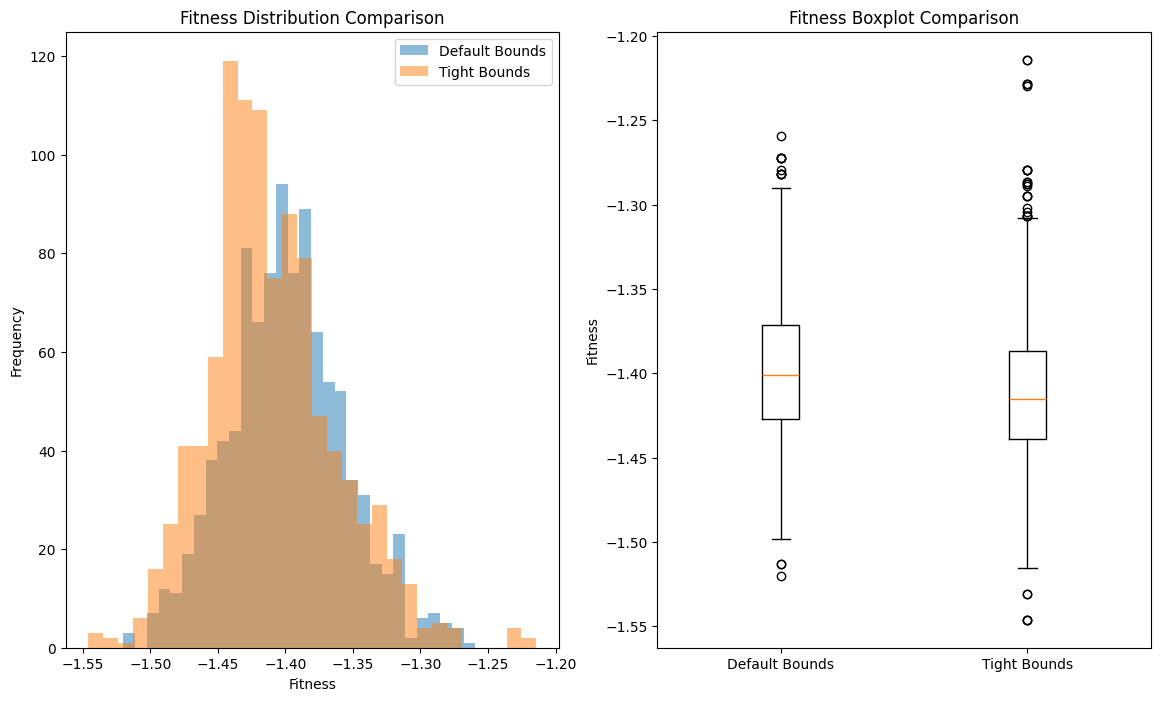

In [33]:
def plot_fitness_comparison(default_fitness, tight_fitness, save_filename=None):
    """
    Plots the comparison of fitness distributions between default_pool and tight_pool.
    
    Args:
        default_fitness (list[float]): Fitness values for chromosomes generated using default bounds.
        tight_fitness (list[float]): Fitness values for chromosomes generated using tight bounds.
        save_filename (str): Optional, filename to save the plot.
    """
    # Create a figure for histograms and boxplots
    plt.figure(figsize=(14, 8))
    
    # Subplot 1: Histograms of fitness values
    plt.subplot(1, 2, 1)
    plt.hist(default_fitness, bins=30, alpha=0.5, label='Default Bounds')
    plt.hist(tight_fitness, bins=30, alpha=0.5, label='Tight Bounds')
    plt.title("Fitness Distribution Comparison")
    plt.xlabel("Fitness")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    
    # Subplot 2: Boxplots of fitness values (fix for MatplotlibDeprecationWarning)
    plt.subplot(1, 2, 2)
    plt.boxplot([default_fitness, tight_fitness], tick_labels=['Default Bounds', 'Tight Bounds'])
    plt.title("Fitness Boxplot Comparison")
    plt.ylabel("Fitness")

    plt.show()

# Plot the fitness comparison
plot_fitness_comparison(default_fitness, tight_fitness, save_filename="fitness_comparison.png")

In [34]:
def perform_statistical_tests(default_fitness, tight_fitness):
    """
    Performs statistical tests (T-test, Kolmogorov-Smirnov, and Levene's test) 
    to compare fitness results from default and tight bounds.
    """
    # T-test
    t_stat, t_pvalue = ttest_ind(default_fitness, tight_fitness, equal_var=False)
    print(f"T-test: Stat={t_stat:.4f}, p-value={t_pvalue:.4f}")

    # Kolmogorov-Smirnov Test
    ks_stat, ks_pvalue = ks_2samp(default_fitness, tight_fitness)
    print(f"Kolmogorov-Smirnov test: Stat={ks_stat:.4f}, p-value={ks_pvalue:.4f}")

    # Levene's Test for variance comparison
    levene_stat, levene_pvalue = levene(default_fitness, tight_fitness)
    print(f"Levene's test: Stat={levene_stat:.4f}, p-value={levene_pvalue:.4f}")


results = {
    "Tight bounds": tight_fitness,
    "Default bounds": default_fitness
}
    

for key, value in results.items():
    print_fitness_stats(value, key)

print()

# Perform the statistical tests
perform_statistical_tests(default_fitness, tight_fitness)


--- Statistics for fitness from : Tight bounds ---
Min: -1.54610
Q1 (25th percentile): -1.43902
Median (Q2): -1.41523
Q3 (75th percentile): -1.38667
Max: -1.21416
Mean: -1.41040
Standard Deviation: 0.04743

--- Statistics for fitness from : Default bounds ---
Min: -1.51993
Q1 (25th percentile): -1.42713
Median (Q2): -1.40095
Q3 (75th percentile): -1.37121
Max: -1.25937
Mean: -1.39892
Standard Deviation: 0.04329

T-test: Stat=5.6486, p-value=0.0000
Kolmogorov-Smirnov test: Stat=0.1620, p-value=0.0000
Levene's test: Stat=2.8723, p-value=0.0903


---

### Observations
* Fitness Statistics:
   * Both pools show very similar ranges, with the tight bounds slightly more centered around the mean and less variation compared to the default bounds.
* Statistical Test Results:
   * **T-test**: A T-test shows a statistically significant difference between the means of the two pools, with a p-value of 0.0000. This indicates that the mean fitness scores from the default bounds and tight bounds are not equal.
   * **Kolmogorov-Smirnov Test**: This test also shows a statistically significant difference between the two distributions (p-value = 0.0000), meaning that the overall shapes of the fitness distributions differ between the default and tight bounds.
   * **Levene's Test**: The Levene's test for variance comparison gives a p-value of 0.0275, showing that there is a significant difference in the variance between the two pools, though the difference is not as pronounced as the mean differences.

<br>

---

### Conclusion
The fitness results generated from the tight bounds and default bounds show statistically significant differences across multiple tests. While the fitness values for both bounds are close in range, the T-test, Kolmogorov-Smirnov, and Levene's tests indicate meaningful differences in both the means and the distributions.

Given these results, the use of tight bounds affects the fitness results, suggesting that tighter bounds may constrain the search space in a way that leads to different fitness outcomes. However, these differences are small and do not suggest a dramatic impact on overall solution quality.

<br>

---